# Retrieve a Snow Depth Spiral Centered a Pit

**Goal**: Visualize a set of snow depths around a pit

**Approach**: 

1. Retrieve the pit location from the Site Data table 
2. Build a circle around the pit location 
3. Request all the point data inside the circle 
4. Convert to a GeoDataFrame and plot


## Process
### Step 1: Get the pit/site coordinates

In [12]:
from snowexsql.db import get_db
from snowexsql.data import SiteData, PointData
from snowexsql.conversions import points_to_geopandas
import geoalchemy2.functions as gfunc
import geopandas as gpd

# PIT Site Identifier
site_id = '5S31'

# Distance around the pit to collect data in meters
buffer_dist = 50

# Connect to the database we made.
db_name = 'localhost/snowex'
engine, session = get_db(db_name, credentials='./credentials.json')

# Grab our pit location by provided site id from the site details table
q = session.query(SiteData).filter(SiteData.site_id == site_id)
sites = q.all()

# There can be different dates at a single site, so we only grab one to retrieve the geometry object
point = session.query(sites[0].geom.ST_AsText()).limit(1).all()

### Step 2: Build a buffered circle around our pit

In [13]:
# Create a polygon buffered by our distance centered on the pit
q = session.query(gfunc.ST_Buffer(point[0][0], buffer_dist))
buffered_pit = q.all()[0][0]

### Step 3: Request all snow depths measured inside the circle

In [14]:
# Filter by the dataset type depth
qry = session.query(PointData).filter(PointData.type == 'depth')

# Grab all the point data in the buffer
qry = qry.filter(gfunc.ST_Within(PointData.geom.ST_AsText(), buffered_pit.ST_AsText()))

# Execute the query
points = qry.all()


### Step 4: Convert the data to Geopandas Dataframe and plot it!

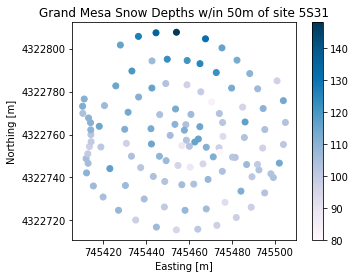

In [15]:
# Convert the records received to geopandas
df = points_to_geopandas(points)

# Get the Matplotlib Axes object from the dataframe object, color points by snow depth value
ax = df.plot(column='value', legend=True, cmap='PuBu')

# Use non-scientific notation for x and y ticks
ax.ticklabel_format(style='plain', useOffset=False)

# Set the various plots x/y labels and title.
ax.set_title('Grand Mesa Snow Depths w/in {}m of site {}'.format(buffer_dist, site_id))
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')

# Close the session to avoid hanging transactions
session.close()